<a href="https://colab.research.google.com/github/Ironman20121/Colabfiles/blob/main/XrayPlayKundan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#all imports
import re
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator


#enabling google cloud storage

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
training_path_cnn ='/content/drive/MyDrive/chest_xray/train'
testing_path_cnn = '/content/drive/MyDrive/chest_xray/test'
training_path_vit = '/content/drive/MyDrive/chest_xray/PNEUMONIA/train'
testing_path_vit = '/content/drive/MyDrive/chest_xray/PNEUMONIA/test'

**Preparing** data for train and testing  for CNN model

In [ ]:
# Define input shape and number of classes
input_shape = (224, 224, 3)
num_classes = 2  # Normal or Abnormal

# Create ImageDataGenerator for training set
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Flow training images in batches using train_datagen
train_generator = train_datagen.flow_from_directory(
    training_path_cnn,
    target_size=(input_shape[0], input_shape[1]),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

# Create ImageDataGenerator for test set
test_datagen = ImageDataGenerator(rescale=1./255)

# Flow test images in batches using test_datagen
test_generator = test_datagen.flow_from_directory(
   testing_path_cnn,
    target_size=(input_shape[0], input_shape[1]),
    batch_size=32,
    class_mode='categorical',  # Assumes categorical classification (Normal or Abnormal)
    shuffle=False  # No shuffling for evaluation
)

Found 5846 images belonging to 2 classes.
Found 640 images belonging to 2 classes.


Epoch 1/10
182/182 [==============================] - 331s 2s/step - loss: 0.3553 - accuracy: 0.8328 - val_loss: 0.3419 - val_accuracy: 0.8547
Epoch 2/10
182/182 [==============================] - 272s 1s/step - loss: 0.2735 - accuracy: 0.8830 - val_loss: 0.3604 - val_accuracy: 0.8328
Epoch 3/10
182/182 [==============================] - 276s 2s/step - loss: 0.2467 - accuracy: 0.8959 - val_loss: 0.2777 - val_accuracy: 0.8875
Epoch 4/10
182/182 [==============================] - 276s 2s/step - loss: 0.2275 - accuracy: 0.9039 - val_loss: 0.2729 - val_accuracy: 0.8844
Epoch 5/10
182/182 [==============================] - 280s 2s/step - loss: 0.2170 - accuracy: 0.9109 - val_loss: 0.2595 - val_accuracy: 0.8953
Epoch 6/10
182/182 [==============================] - 279s 2s/step - loss: 0.2062 - accuracy: 0.9142 - val_loss: 0.3552 - val_accuracy: 0.8750
Epoch 7/10
182/182 [==============================] - 282s 2s/step - loss: 0.1963 - accuracy: 0.9123 - val_loss: 0.2660 - val_accuracy: 0.8922

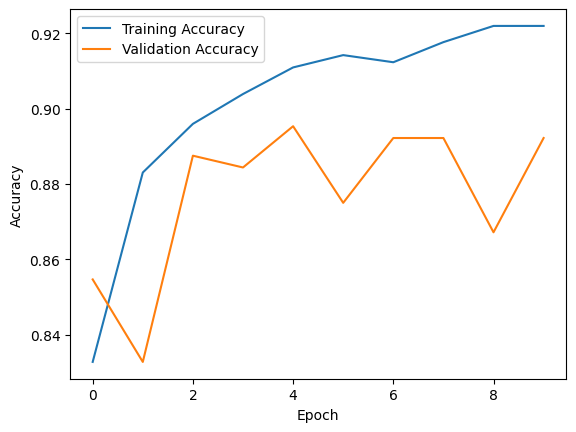

In [ ]:
base_model = tf.keras.applications.VGG16(
    input_shape=input_shape,
    include_top=False,
    weights='imagenet'
)

# stoping the base model
base_model.trainable = False

# Build on top of it  model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // 32,
    epochs=10,
    validation_data=test_generator,
    validation_steps=test_generator.samples // 32
)


20/20 [==============================] - 27s 1s/step - loss: 0.2807 - accuracy: 0.8922
Test Loss: 0.28072530031204224
Test Accuracy: 0.8921874761581421


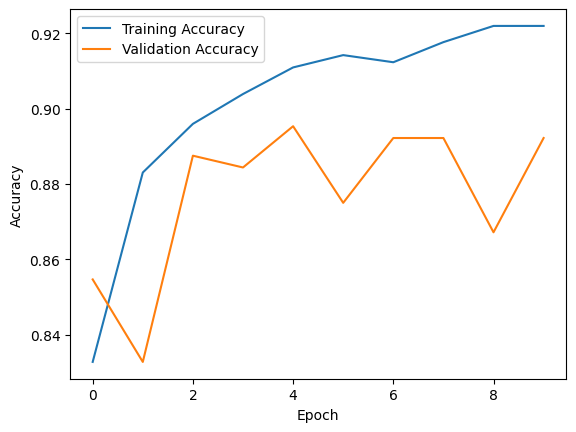

In [ ]:
# Evaluate the model
evaluation = model.evaluate(test_generator, steps=test_generator.samples // 32)
print("Test Loss:", evaluation[0])
print("Test Accuracy:", evaluation[1])

# Plot training and validation accuracy over epochs
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

model.save('path/to/save/myVGG16.h5')

In [ ]:
import tensorflow as tf
import numpy as np

# Define the FGSM attack function
def fgsm_attack(model, original_images, batch_labels, epsilon):
    with tf.GradientTape() as tape:
        tape.watch(original_images)
        predictions = model(original_images)
        loss = tf.keras.losses.categorical_crossentropy(batch_labels, predictions)

    gradients = tape.gradient(loss, original_images)
    signed_grad = tf.sign(gradients)
    adversarial_images = original_images + epsilon * signed_grad
    adversarial_images = tf.clip_by_value(adversarial_images, 0, 1)
    return adversarial_images

# Example: Define original_images
original_images = np.random.rand(10, 224, 224, 3)

# Example: Define batch_labels
batch_labels = np.random.randint(0, 2, size=(10, 2))  # Assuming 2 classes

# Convert NumPy arrays to TensorFlow tensors
original_images_tf = tf.convert_to_tensor(original_images)
batch_labels_tf = tf.convert_to_tensor(batch_labels)

# Apply FGSM attack
epsilon = 0.1  # Example epsilon value
adversarial_images = fgsm_attack(model, original_images_tf, batch_labels_tf, epsilon)

In [ ]:
# Define the ImageDataGenerator for the test set
test_datagen = ImageDataGenerator(rescale=1./255)
test_path = '/content/drive/MyDrive/chest_xray/test'
test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)


Found 640 images belonging to 2 classes.


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from PIL import Image

In [ ]:
# Directory to save adversarial examples
adversarial_dir = '/content/drive/MyDrive/chest_xray/adversarial_examples'
#os.makedirs(adversarial_dir, exist_ok=True)

# Apply the FGSM attack on batches of images, evaluate the model, and save the adversarial examples
total_samples = test_generator.samples
batch_size = test_generator.batch_size
num_batches = np.ceil(total_samples / batch_size)

all_true_labels = []
all_predicted_labels = []

for i, (batch_images, batch_labels) in enumerate(test_generator):
    # Convert NumPy arrays to TensorFlow tensors
    batch_images_tf = tf.convert_to_tensor(batch_images)

    # Apply FGSM attack
    #adversarial_images = fgsm_attack(model, batch_images_tf, batch_labels, epsilon)  # Pass epsilon here

    predictions = model.predict(adversarial_images)
    predicted_labels = np.argmax(predictions, axis=1)
    true_labels = np.argmax(batch_labels, axis=1)
    all_true_labels.extend(true_labels)
    all_predicted_labels.extend(predicted_labels)

    # Save the adversarial images
    #for j, img in enumerate(adversarial_images):
        #img_pil = Image.fromarray((img.numpy() * 255).astype(np.uint8))
        #img_pil.save(os.path.join(adversarial_dir, f'adv_{i * batch_size + j}.png'))

    if i + 1 >= num_batches:
        break



1/1 [==============================] - 1s 1s/step


In [ ]:
# Evaluate the model's performance on the adversarial examples
accuracy = accuracy_score(all_true_labels, all_predicted_labels)
precision = precision_score(all_true_labels, all_predicted_labels, average='macro')
recall = recall_score(all_true_labels, all_predicted_labels, average='macro')
f1 = f1_score(all_true_labels, all_predicted_labels, average='macro')

print(f'Accuracy on adversarial examples: {accuracy:.2%}')
print(f'Precision on adversarial examples: {precision:.2%}')
print(f'Recall on adversarial examples: {recall:.2%}')
print(f'F1-score on adversarial examples: {f1:.2%}')

Accuracy on adversarial examples: 0.47%
Precision on adversarial examples: 0.46%
Recall on adversarial examples: 0.54%
F1-score on adversarial examples: 0.47%


In [ ]:
# Evaluate the model's performance after training to resist adversarial examples
accuracy = accuracy_score(all_true_labels, all_predicted_labels)
precision = precision_score(all_true_labels, all_predicted_labels, average='macro')
recall = recall_score(all_true_labels, all_predicted_labels, average='macro')
f1 = f1_score(all_true_labels, all_predicted_labels, average='macro')

print(f'Accuracy on adversarial examples: {accuracy:.2%}')
print(f'Precision on adversarial examples: {precision:.2%}')
print(f'Recall on adversarial examples: {recall:.2%}')
print(f'F1-score on adversarial examples: {f1:.2%}')

Accuracy on adversarial examples: 61.25%
Precision on adversarial examples: 48.55%
Recall on adversarial examples: 49.81%
F1-score on adversarial examples: 40.49%


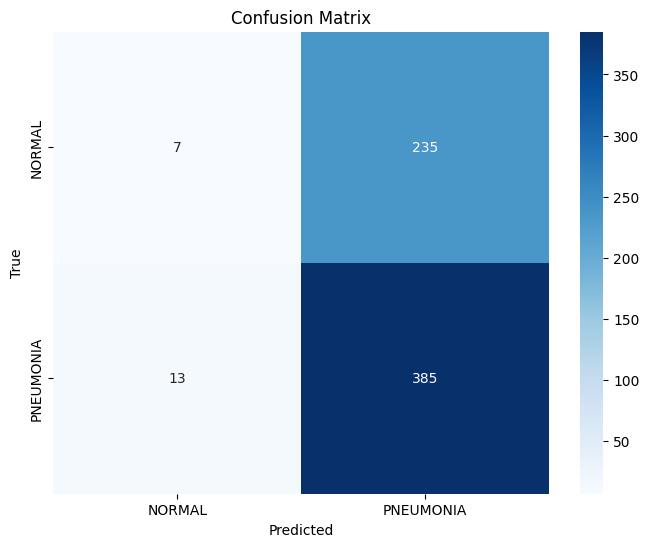

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Plot confusion matrix
conf_mat = confusion_matrix(all_true_labels, all_predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=test_generator.class_indices.keys(),
            yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

1/1 [==============================] - 1s 1s/step - loss: 0.1624 - accuracy: 0.9688


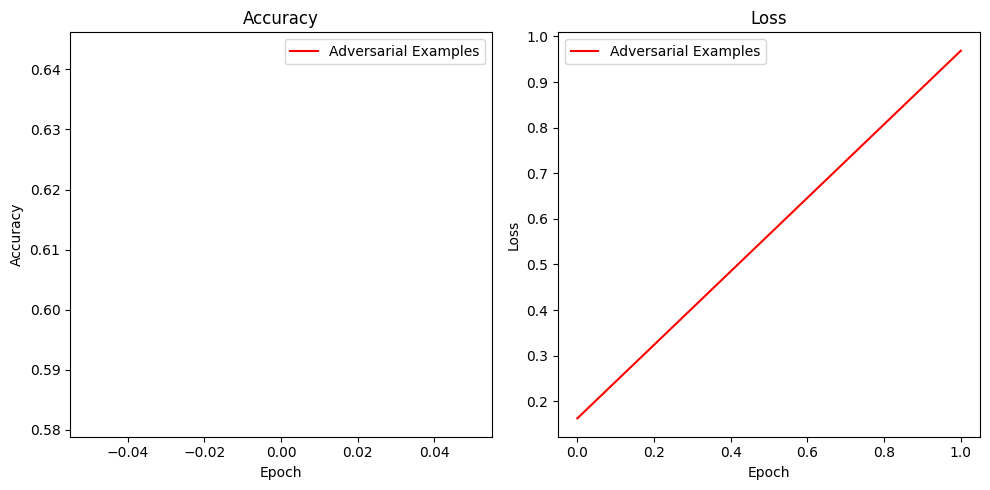

In [ ]:
# Calculate loss for adversarial examples
loss_adv = model.evaluate(adversarial_images, batch_labels)

# Plotting accuracy and loss
plt.figure(figsize=(10, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(accuracy, label='Adversarial Examples', color='r')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(loss_adv, label='Adversarial Examples', color='r')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Display classification report
class_report = classification_report(all_true_labels, all_predicted_labels, target_names=test_generator.class_indices.keys())
print("Classification Report:\n", class_report)

Classification Report:
               precision    recall  f1-score   support

      NORMAL       0.35      0.03      0.05       242
   PNEUMONIA       0.62      0.97      0.76       398

    accuracy                           0.61       640
   macro avg       0.49      0.50      0.40       640
weighted avg       0.52      0.61      0.49       640

